# Topic Modelling
## Imports

In [1]:
import gensim
import nltk
import pandas as pd
import re
from datetime import datetime
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from gensim.models import TfidfModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [2]:
def string_to_date(str_date):
    if len(str(str_date)) == "":
        return None
    for fmt in ('%d %B %Y', '%d %b %Y', '%B %Y', "%b %Y", "%Y"):
        try:
            return datetime.strptime(str(str_date), fmt)
        except ValueError:
            pass
    raise ValueError(f'no valid date format found for {str_date}')

In [3]:
letters = pd.read_pickle("letters.pickle")
original_dates_corrected = pd.read_csv("original_dates.csv", sep=";")

letters = pd.merge(letters, original_dates_corrected, left_index=True, right_on="index").dropna()
letters.original_date_corrected = letters.original_date_corrected.apply(string_to_date)
letters = letters.query("category != 'Mint'")
letters = letters[letters["languages"].apply(lambda ls : ls != ["Latin"])]

destinataire = pd.read_csv("destinataire.csv", sep=";", names=["index", "receiver", "royal"])
destinataire["royal"] = destinataire.royal.apply(lambda x : type(x) is str)

letters = pd.merge(letters, destinataire, left_on="index", right_on = "index")
letters.head(2)

,author,category,title,manuscript,original_date,original_place,languages,letter_content,index,original_date_corrected,receiver,royal
0,Isaac Newton,Mathematics,"Letter from Newton to a friend, together with ...",MS Add. 9597/2/18/3,23 February 1668/9,England,"[English, Latin]",3 Trinity College Cambridge Feb: 23d 16689 Sir...,NATP00226,1668-02-23 00:00:00,unknown,False
1,Isaac Newton,Mathematics,"Letter from Newton to Francis Aston, dated 18 ...",MS Add. 9597/2/18/4,18 May 1669,England,"[English, Latin]",4 Trinity College Cambridge May 18 1669 Franci...,NATP00227,1669-05-18 00:00:00,Francis Aston,False


## Data preprocessing

In [4]:
letters.letter_content = letters.letter_content.apply(lambda txt : txt.lower())
letters.letter_content[:2]

0    3 trinity college cambridge feb: 23d 16689 sir...
1    4 trinity college cambridge may 18 1669 franci...
Name: letter_content, dtype: object

In [5]:
letters.letter_content = letters.letter_content.apply(lambda txt : txt.lower())
letters.letter_content[:2]

0    3 trinity college cambridge feb: 23d 16689 sir...
1    4 trinity college cambridge may 18 1669 franci...
Name: letter_content, dtype: object

In [6]:
letters.letter_content = letters.letter_content.apply(lambda txt : re.sub("[^a-zA-Z\s]+", "", txt))
letters.letter_content[:2]

0     trinity college cambridge feb d  sir i promis...
1     trinity college cambridge may   francis since...
Name: letter_content, dtype: object

In [7]:
letters.letter_content = letters.letter_content.apply(lambda txt : txt.split())
letters.letter_content[:2]

0    [trinity, college, cambridge, feb, d, sir, i, ...
1    [trinity, college, cambridge, may, francis, si...
Name: letter_content, dtype: object

In [8]:
def remove_non_english(tokens):
    english_tokens = []
    for i in range(0, len(tokens), 10):
        if detect(" ".join(tokens[i:i+10])) != "en":
            english_tokens.append(tokens[i:i+10])
    return english_tokens

In [9]:
letters.letter_content = letters.letter_content.apply(lambda words : [word for word in words if not len(word) < 3])
letters.letter_content[:2]

0    [trinity, college, cambridge, feb, sir, promis...
1    [trinity, college, cambridge, may, francis, si...
Name: letter_content, dtype: object

In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
letters.letter_content = letters.letter_content.apply(lambda words : [lemmatizer.lemmatize(word) for word in words])

In [12]:
latin_stopwords = ["bee", "erit", "potest", "a","ab","ac","ad","adhuc","aliqui","aliquis","an","ante","apud","at","atque","aut","autem","contra","cui","cuius","cujus","cum","cur","de","deinde","dum","e","ea","ego","ei","eius","ejus","enim","eo","eorum","erant","erat","ergo","es","esse","esset","est","et","etiam","etsi","eum","ex","fio","fuit","haec","haud","hic","his","hoc","iam","id","idem","igitur","illa","ille","in","infra","inter","interim","ipse","is","ita","jam","magis","me","mihi","modo","mox","nam","ne","nec","necque","neque","nisi","nobis","non","nos","o","ob","per","possum","post","pro","qua","quae","quam","quare","quem","qui","quia","quibus","quicumque","quid","quidem","quilibet","quis","quisnam","quisquam","quisque","quisquis","quo","quod","quoniam","quos","re","rebus","rem","res","se","secundum","sed","si","sibi","sic","sicut","sine","sit","siue","sive","sua","sub","sui","sum","sunt","super","suus","tam","tamen","tandem","te","tibi","trans","tu","tum","ubi","uel","uero","uos","ut","vel","vero","vos"]

In [13]:
letters.letter_content = letters.letter_content.apply(lambda words : [word for word in words if not word in stopwords.words("english") and not word in latin_stopwords])
letters.letter_content[:2]

0    [trinity, college, cambridge, feb, sir, promis...
1    [trinity, college, cambridge, may, francis, si...
Name: letter_content, dtype: object

In [14]:
word_document_frequency = dict()
for index, row in letters.iterrows():
    document_words = set()
    for word in row["letter_content"]:
        if word in document_words:
            continue
        document_words.add(word)
        if not word in word_document_frequency.keys():
            word_document_frequency[word] = 1
        else:
            word_document_frequency[word] += 1

In [15]:
words_to_remove = set()
for word, frequency in word_document_frequency.items():
    if frequency < 10 or frequency > 0.9 * len(letters):
        words_to_remove.add(word)

In [16]:
letters.letter_content = letters.letter_content.apply(lambda words : [word for word in words if not word in words_to_remove])

## TFIDF representation

In [17]:
dct = Dictionary(letters.letter_content)  # fit dictionary
corpus = [dct.doc2bow(line) for line in letters.letter_content]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus]  # apply model to the first corpus document

## Train LDA Model

In [24]:
avg_scores = []
ranges = range(5,20,1)
for n in tqdm(ranges):
    lda = LdaModel(vector, id2word=dct, num_topics=n, alpha='auto', eta='auto', passes=10, iterations=100, eval_every=None, random_state=345)
    avg_score = 0
    for top_topic in lda.top_topics(vector, texts=letters.letter_content, coherence='c_v'):
        avg_score += top_topic[1]
    avg_score/=n
    avg_scores.append(avg_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.31s/it]


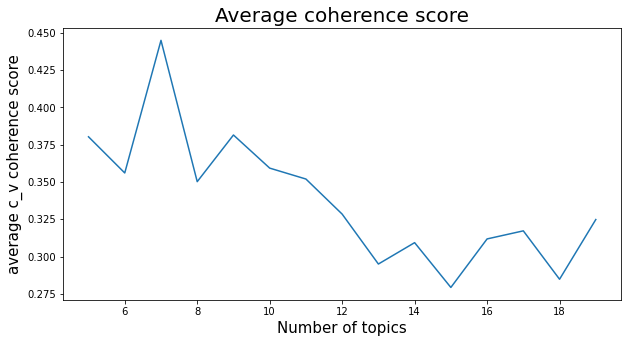

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(ranges, avg_scores)
plt.title("Average coherence score", fontsize=20)
plt.xlabel("Number of topics", fontsize=15)
plt.ylabel("average c_v coherence score", fontsize=15)
plt.show()

In [18]:
lda = LdaModel(vector, id2word=dct, num_topics=7, alpha='auto', eta='auto', passes=10, iterations=100, eval_every=None, random_state=345)
lda.show_topics(num_words=5)

[(0,
  '0.003*"oblige" + 0.003*"pray" + 0.003*"among" + 0.003*"putting" + 0.003*"occasion"'),
 (1,
  '0.006*"oldenburg" + 0.005*"henry" + 0.004*"society" + 0.003*"cambridge" + 0.003*"london"'),
 (2,
  '0.013*"data" + 0.012*"series" + 0.011*"leibnitz" + 0.009*"june" + 0.008*"par"'),
 (3,
  '0.009*"colour" + 0.006*"prism" + 0.006*"ray" + 0.005*"light" + 0.005*"experiment"'),
 (4,
  '0.002*"series" + 0.002*"pag" + 0.002*"leibnitz" + 0.002*"carrier" + 0.002*"long"'),
 (5,
  '0.009*"quations" + 0.008*"gregory" + 0.008*"root" + 0.008*"series" + 0.007*"curve"'),
 (6,
  '0.016*"latitude" + 0.013*"min" + 0.010*"minute" + 0.007*"fit" + 0.007*"tangent"')]

## Correspondants analysis

In [19]:
names = ["Henry Oldenburg", "John Collins", "Edmund Halley", "John Wallis"]

In [20]:
data = dict()
for name in names:
    histogram = [0]*7
    correspondence_indices = list(letters.query("(author == 'Isaac Newton' and receiver == @name) or (author == @name and receiver == 'Isaac Newton')").index)
    for index in correspondence_indices:
        for topic in lda.get_document_topics(vector[index]):
            histogram[topic[0]]+= topic[1]
    data[name] = [v/len(correspondence_indices) for v in histogram]
data = pd.DataFrame.from_dict(data, orient='index', columns=["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7"]).reset_index().rename(columns={"index": "Name",
"Topic 1" : "Courtesies", "Topic 2" : "Royal Society","Topic 3" : "Math data","Topic 4" : "Optic","Topic 5" : "Math data bis","Topic 6" : "Mathematics", "Topic 7" : "Geography"})

In [22]:
df = pd.melt(data, id_vars="Name", var_name="topic", value_name="frequency")

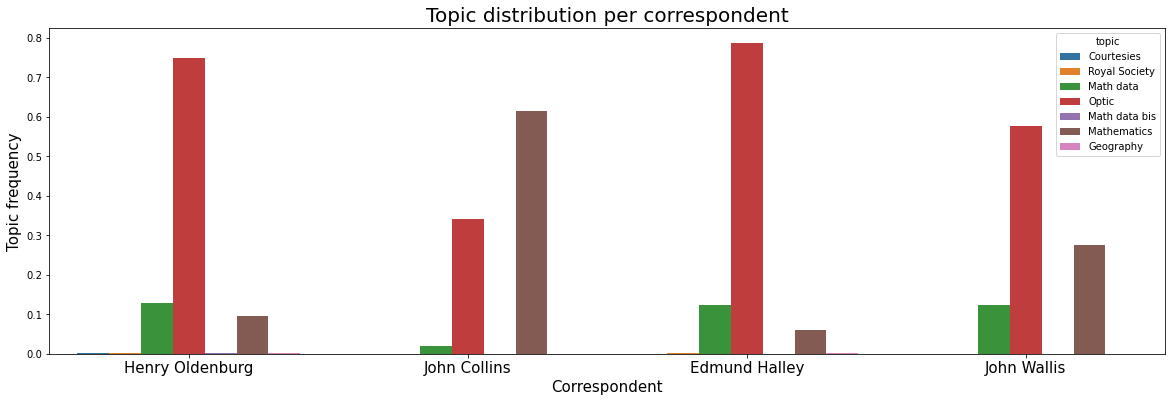

In [23]:
fig, axes = plt.subplots(figsize=(20,6))
sns.barplot(data=df, x = "Name", y = "frequency", hue="topic")
plt.title("Topic distribution per correspondent", fontsize=20)
plt.xlabel("Correspondent", fontsize=15)
plt.ylabel("Topic frequency", fontsize=15)
plt.xticks(size=15)
plt.show()